In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import time

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
image_dataset = ImageFolder(path, transform,)
train_size = int(0.75*len(image_dataset))
test_size = len(image_dataset)-train_size
train_data, test_data = random_split(image_dataset, [train_size, test_size])
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(test_data, shuffle=False, batch_size=32)

This project is compute intensive. If you have a mps or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


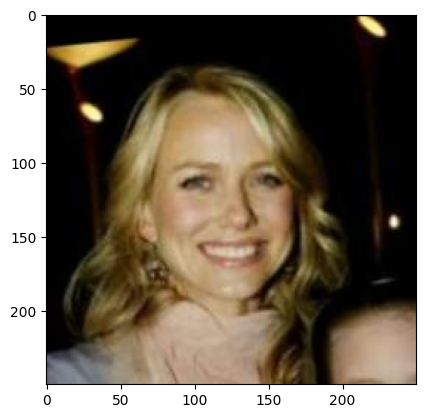

In [5]:
for x,y in train_loader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
for x, _ in train_loader:
    x = x.to("mps")
    print(x.device)
    break

mps:0


In [7]:
print(x.shape)

torch.Size([32, 3, 250, 250])


The dimension of the data is 32 by 3 by 250 by 250. The 32 is the batch size of the data. 3 is the 3 color channel. The two 250 are the height and width dimension of the image.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In this model we will use Conv2d, MaxPool2d, and ReLU for the encoder part. For the decoder part, we will use ConvTranspose2d, ReLU, Conv2d, and Sigmoid.

In [8]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.enc_activation1 = nn.ReLU()
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.enc_activation2 = nn.ReLU()
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.enc_activation3 = nn.ReLU()
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Decoder layers
        self.dec_convtrans1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_activation1 = nn.ReLU()
        self.dec_conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dec_activation2 = nn.ReLU()
        self.dec_convtrans2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.dec_activation3 = nn.ReLU()
        self.dec_conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dec_activation4 = nn.ReLU()
        self.dec_convtrans3 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2, padding=1) 
        self.dec_activation5 = nn.Sigmoid()

    def encoder(self, x):
        layer1 = self.enc_activation1(self.enc_conv1(x))
        layer2 = self.enc_pool1(layer1)
        layer3 = self.enc_activation2(self.enc_conv2(layer2))
        layer4 = self.enc_pool2(layer3)
        layer5 = self.enc_activation3(self.enc_conv3(layer4))
        out = self.enc_pool3(layer5)
        return out

    def decoder(self, x):
        layer1 = self.dec_activation1(self.dec_convtrans1(x))
        layer2 = self.dec_activation2(self.dec_conv1(layer1))
        layer3 = self.dec_activation3(self.dec_convtrans2(layer2))
        layer4 = self.dec_activation4(self.dec_conv2(layer3))
        out = self.dec_activation5(self.dec_convtrans3(layer4))
        return out

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return out

In [9]:
autoencoder = AE()

In [10]:
autoencoder.to("mps")

AE(
  (enc_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation1): ReLU()
  (enc_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation2): ReLU()
  (enc_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation3): ReLU()
  (enc_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec_convtrans1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation1): ReLU()
  (dec_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_activation2): ReLU()
  (dec_convtrans2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation3): ReLU

In [11]:
next(autoencoder.parameters()).device

device(type='mps', index=0)

In [12]:
encoded = autoencoder.encoder(x)

In [13]:
print(encoded.shape)

torch.Size([32, 128, 31, 31])


In [14]:
print(autoencoder.decoder(encoded).shape)

torch.Size([32, 3, 250, 250])


In [15]:
pytorch_total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

In [16]:
print(pytorch_total_params)

235139


In [17]:
y = autoencoder.decoder(encoded)

In [18]:
y = y.cpu()

In [19]:
y = y[0].permute(1, 2, 0)

In [20]:
print(y.shape)

torch.Size([250, 250, 3])


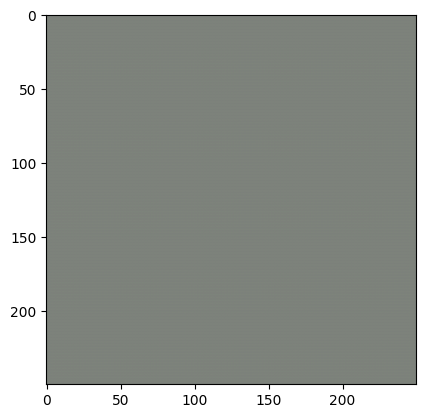

In [21]:
plt.imshow(y.detach().numpy())

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

Let initialize our model by calling the constructor on AE and assign it to model

In [22]:
model = AE()

Next we will move our model into GPU for faster training since it is available to us.

In [23]:
model.to("mps")

AE(
  (enc_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation1): ReLU()
  (enc_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation2): ReLU()
  (enc_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation3): ReLU()
  (enc_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec_convtrans1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation1): ReLU()
  (dec_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_activation2): ReLU()
  (dec_convtrans2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation3): ReLU

Let's encode our input and print out the shape.

In [24]:
encoded = model.encoder(x)
print(encoded.shape)

torch.Size([32, 128, 31, 31])


We can see that our input has been reduced from 3 by 250 by 250 to 128 by 31 by 31 through our encoder. Next let use the encoded data and put it through the decoder to make sure that it decodes the data back to the right size which is 3 by 250 by 250. The number 32 should stay the same since it is the batch size.

In [25]:
decoded = model.decoder(encoded)
print(decoded.shape)

torch.Size([32, 3, 250, 250])


This confirm that we the model work correctly as we wanted it to.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

This code was borrow from stack overflow. Source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

In [26]:
total_params = sum(p.numel() for p in autoencoder.parameters())
print(total_params)

235139


In [27]:
optim = torch.optim.Adam(model.parameters(), lr=0.0005)

Since we are trying to minimize the different between the input image X and the reconstructed image X', we are going to use MSELoss as our loss function.

In [28]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

Let define a function that will train the model for one epoch and report the average loss in that epoch for us as well as a function that keep track of how much time has elapsed to see how long our training takes.

In [29]:
def time_elapse(start):
    result = time.time()-start
    hours = int(result // 3600)
    minutes = int((result % 3600) // 60)
    seconds = result % 60
    return f"{hours}h:{minutes}m:{seconds:.2f}s"

In [30]:
def train_one_epoch(start_time):
    last_loss = 0
    for i, data in enumerate(train_loader):
        inputs = data[0]
        inputs = inputs.to("mps")
        optim.zero_grad()
        outputs = model.forward(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optim.step()
        running_loss = loss.item()
        print(" Batch {} loss: {} Time elapsed: {}".format(i+1, running_loss, time_elapse(start_time)))
        last_loss += running_loss
    avg_train_loss = last_loss/(i+1)
    return avg_train_loss
    

We will run the training for 50 epochs

In [31]:
epoch_number = 0
EPOCHS = 50
time_start = time.time()
for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number+1))
    model.train(True)
    avg_train_loss = train_one_epoch(time_start)
    running_test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):
            test_inputs = test_data[0]
            test_inputs = test_inputs.to("mps")
            test_outputs = model.forward(test_inputs)
            test_loss = loss_function(test_outputs, test_inputs)
            running_test_loss += test_loss
            print(" Batch {} test loss: {} Time elapsed: {}".format(i+1, test_loss, time_elapse(time_start)))
    avg_test_loss = running_test_loss/(i+1)
    print(" Average train loss: {}".format(avg_train_loss))
    print(" Average test loss: {}".format(avg_test_loss))
    epoch_number += 1

EPOCH 1:
 Batch 1 loss: 0.09828858077526093 Time elapsed: 0h:0m:0.39s
 Batch 2 loss: 0.09119372814893723 Time elapsed: 0h:0m:0.55s
 Batch 3 loss: 0.09279059618711472 Time elapsed: 0h:0m:0.72s
 Batch 4 loss: 0.09778004884719849 Time elapsed: 0h:0m:0.88s
 Batch 5 loss: 0.09549536556005478 Time elapsed: 0h:0m:1.03s
 Batch 6 loss: 0.10010811686515808 Time elapsed: 0h:0m:1.19s
 Batch 7 loss: 0.08769134432077408 Time elapsed: 0h:0m:1.34s
 Batch 8 loss: 0.09703123569488525 Time elapsed: 0h:0m:1.49s
 Batch 9 loss: 0.09068968892097473 Time elapsed: 0h:0m:1.65s
 Batch 10 loss: 0.08751103281974792 Time elapsed: 0h:0m:1.81s
 Batch 11 loss: 0.09477990865707397 Time elapsed: 0h:0m:1.96s
 Batch 12 loss: 0.09378404170274734 Time elapsed: 0h:0m:2.12s
 Batch 13 loss: 0.08618105947971344 Time elapsed: 0h:0m:2.28s
 Batch 14 loss: 0.09295816719532013 Time elapsed: 0h:0m:2.43s
 Batch 15 loss: 0.08322043716907501 Time elapsed: 0h:0m:2.59s
 Batch 16 loss: 0.0732816532254219 Time elapsed: 0h:0m:2.74s
 Batch 17

Let save our model parameter into a file

In [32]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [33]:
model.load_state_dict(torch.load('model_state_dict.pth'))

<All keys matched successfully>

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Let's choose a random image from the test loader and use it since the model did not learn anything about the test data.

In [64]:
for _, x in enumerate(test_loader):
    print(x[0][3].shape)
    x_input = x[0][3]
    x = x[0][3].permute(1, 2, 0)
    break

torch.Size([3, 250, 250])


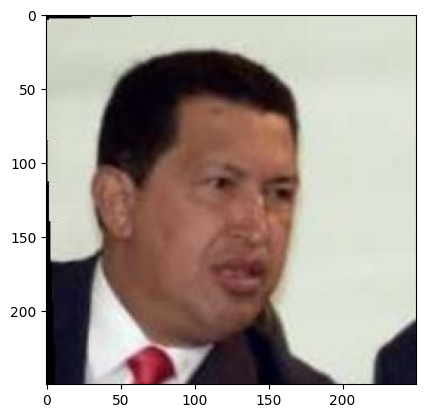

In [65]:
plt.imshow(x)

Move the tensor into GPU in order to run it since our model is in GPU.

In [66]:
x_input = x_input.to("mps")

Let's verify that the shape is right.

In [67]:
x_input.shape

torch.Size([3, 250, 250])

Since the model take a tensor that need a batch size, let's add an extra dimension of size 1.

In [68]:
x_input = x_input.unsqueeze(0)

We can now run the tensor through the autoencoder.

In [69]:
x_prime = model.forward(x_input)

We also want to see what the model encode our input into, so let's just run the encoder part and see what happens to the image.

In [70]:
encoded = model.encoder(x_input)

In [71]:
encoded.shape

torch.Size([1, 128, 31, 31])

As we can see the encoded tensor is of shape 1 by128 by 31 by 31 which means it has 128 channels. So let's see what the average of those 128 channels looks like.

In [72]:
average_encoded = torch.mean(encoded.squeeze(), dim=0)

In [73]:
average_encoded.shape

torch.Size([31, 31])

In [74]:
average_encoded = average_encoded.cpu()

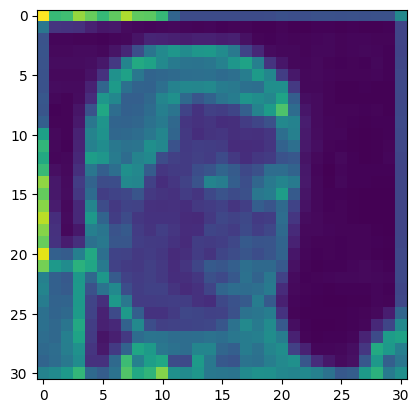

In [75]:
plt.imshow(average_encoded.detach().numpy())

As we can see it is encoded into a pattern that outline the image around important details such as clothes, head, facial features.

Let's see what some of the channels in the encoded image look like.

In [76]:
encoded_0 = encoded[0,2]

In [77]:
encoded_0.shape
encoded_0 = encoded_0.cpu()

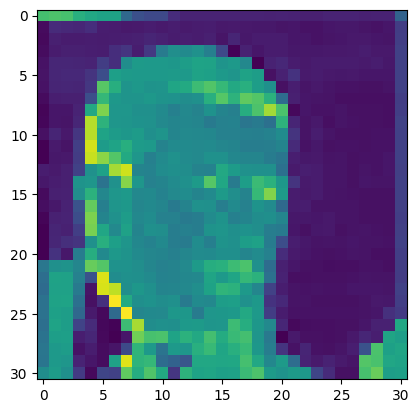

In [78]:
plt.imshow(encoded_0.detach().numpy())

As we can see, in this channels, the face, facial features and attires are highlighted.

Now Let's see what the autoencoder generated on a full pass of the image.

In [79]:
x_prime = x_prime.squeeze()

In [80]:
x_prime.shape

torch.Size([3, 250, 250])

In [81]:
x_prime = x_prime.permute(1, 2, 0)

In [82]:
x_prime = x_prime.cpu()

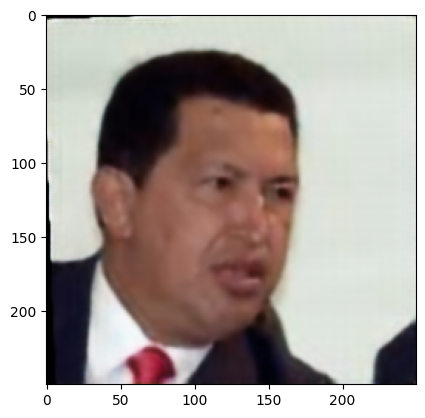

In [83]:
plt.imshow(x_prime.detach().numpy())

We can see that the image is almost undistinguishable to the original. However, if we looks closely, we can see that the pattern on the tie is missing on the reconstructed image.

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Let's us add some random normally distrubuted noise to the encoded image.

In [84]:
encoded = encoded.to("mps")

In [85]:
encoded = encoded+(torch.rand_like(encoded))

In [86]:
encoded.shape

torch.Size([1, 128, 31, 31])

In [87]:
average_encoded = torch.mean(encoded.squeeze(), dim=0)
average_encoded.shape

torch.Size([31, 31])

Let see what the average of the 128 channels look like now.

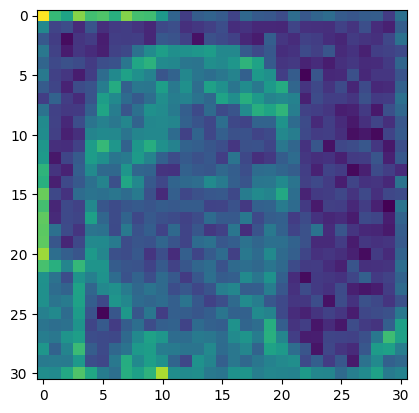

In [88]:
average_encoded = average_encoded.cpu()
plt.imshow(average_encoded.detach().numpy())

We can see that the encoded image is very noisy. However, some outline can still be seen around the shoulder and face of the image. Now let's try to decode the image and see what happens.

In [89]:
encoded.shape
decoded_noise = model.decoder(encoded)

In [90]:
decoded_noise = decoded_noise.squeeze()
decoded_noise.shape

torch.Size([3, 250, 250])

In [91]:
decoded_noise = decoded_noise.permute(1, 2, 0)

Code from Fall-23-APML-Public/Tutorials/AE.ipynb

In [92]:
def plot_image_pair(x,y):
    plt.subplot(121)
    plt.imshow(x.detach().cpu().squeeze())
    plt.subplot(122)
    plt.imshow(y.detach().cpu().squeeze())

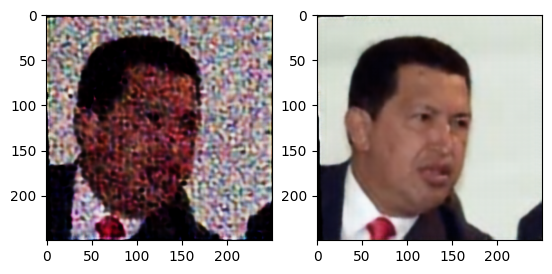

In [93]:
decoded_noise = decoded_noise.cpu()
plot_image_pair(decoded_noise, x_prime)

We can see that the decoded image of the noisy latent space representation also came out very noisy compare to the normal one. However, it was still able to generate a good enough details image that can be perceived as faces.